<a href="https://colab.research.google.com/github/gisturiz/llm_research_agent/blob/main/Research_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Step LLM Research Agent

In this notebook, we will build a multi-step research tool making use of multiple agents each of which are equipped with specialized tools for performing their tasks.

This agent will be built using LangGraph and have web-search, RAG search, arXiv search, and CDP SDK functionalities.

### First we need to download our Python dependencies

In [ ]:
!pip install -qU datasets langchain-pinecone langchain-openai langchain langchain-core langgraph semantic-router serpapi google-search-results

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 21.9 MB/s eta 0:00:00
   ━━━

## Setup our knowledge base

We will download a dataset from Huggingface and upload it to a vector database in Pinecone.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("gisturiz/arxiv_blockchain_crypto_papers_semantic", split="train")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

all_chunk_metadata.json:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/54460 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'references'],
    num_rows: 54460
})

In [ ]:
dataset[0]

{'id': '2011.13240#0',
 'title': 'Blockchain mechanism and distributional characteristics of cryptos',
 'content': 'Blockchain mechanism and distributional characteristics of\ncryptos∗\nMin-Bin Lin†Kainat Khowaja‡Cathy Yi-Hsuan Chen§\nWolfgang Karl H\x7f ardle¶\nAbstract\nWe investigate the relationship between underlying blockchain mechanism of cryptocurren-\ncies and its distributional characteristics. In addition to price, we emphasise on using actual\nblock size and block time as the operational features of cryptos.',
 'prechunk_id': '',
 'postchunk_id': '2011.13240#1',
 'references': '2011.13240'}

## Initialize embedding encoder

You can get an OpenAI API key here - https://platform.openai.com/

In [ ]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")

encoder = OpenAIEncoder(name="text-embedding-3-small")

OpenAI API key: ··········


## Initialize our Pineconde index

You can get a Pinecone account and API key here - https://www.pinecone.io/

In [ ]:
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or getpass("Pinecone API key: ")

# configure client
pc = Pinecone(api_key=api_key)

Pinecone API key: ··········


In [ ]:
import time

index_name = "better-rag-chunking"

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=1536,  # dimensionality of embed 3
        metric='dotproduct'
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}

We can now populate our vector index with the following command

In [ ]:
from tqdm.auto import tqdm

# easier to work with dataset as pandas dataframe
data = dataset.to_pandas().iloc[:10000]

batch_size = 128

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    batch = data[i:i_end].to_dict(orient="records")
    # get batch of data
    metadata = [{
        "title": r["title"],
        "content": r["content"],
        "arxiv_id": r["id"],
        "references": r["references"]
    } for r in batch]
    # generate unique ids for each chunk
    ids = [r["id"] for r in batch]
    # get text content to embed
    content = [r["content"] for r in batch]
    # embed text
    embeds = encoder(content)
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

## Define our Graph State

Let's define a custom graph state to support our agent-oriented decision making.


In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

There are 3 parts to our agent state, those are:

* `input`: this is the user's most recent query, usually this would be a question that we want to answer with our research agent.
* `chat_history`: we are building a conversational agent that can support multiple interactions, to allow previous interactions to provide additional context throughout our agent logic we include the chat history in the agent state.
* `intermediate_steps`: provides a record of all steps the research agent will take between the user asking a question via `input` and the agent providing a final answer. This can include things like "search arxiv", "perform general purpose web search", etc. These intermediate steps are crucial to allowing the agent to follow a path of coherent actions and ultimately producing an informed final answer.

## Custom tools

Now we can define the different tools we want our model to have access to during its research.

## ArXiv article fetching

The `fetch_arxiv` tool will allow our agent to get the summary of a specific paper given an ArXiv paper ID. To do this, we will simply send a GET request to arXiv and use regex to extract the paper abstract.

In [ ]:
from langchain_core.tools import tool
import requests
import re

# our regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    return re_match.group(1)

Let's test our tool

In [ ]:
print(
    fetch_arxiv.invoke(input={"arxiv_id": "2011.13240"})
)

We investigate the relationship between underlying blockchain mechanism of
cryptocurrencies and its distributional characteristics. In addition to price,
we emphasise on using actual block size and block time as the operational
features of cryptos. We use distributional characteristics such as fourier
power spectrum, moments, quantiles, global we optimums, as well as the measures
for long term dependencies, risk and noise to summarise the information from
crypto time series. With the hypothesis that the blockchain structure explains
the distributional characteristics of cryptos, we use characteristic based
spectral clustering to cluster the selected cryptos into five groups. We
scrutinise these clusters and find that indeed, the clusters of cryptos share
similar mechanism such as origin of fork, difficulty adjustment frequency, and
the nature of block size. This paper provides crypto creators and users with a
better understanding toward the connection between the blockchain protocol
de

## Web search tool

We will be using SerpAPIs Google search tool. You can get an API here - https://serpapi.com/

In [ ]:
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")
}

@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

SerpAPI key: ··········


Now lets test this tool.

In [ ]:
print(
    web_search.invoke(input={"query": "ethereum"})
)

Ethereum price today, ETH to USD live price, marketcap ...
The live Ethereum price today is $2680.84 USD with a 24-hour trading volume of $17606983346.23 USD. We update our ETH to USD price in real-time.
https://coinmarketcap.com/currencies/ethereum/
---
r/ethereum
Use this thread to discuss Ethereum topics, news, events, and even price! Price discussion posted elsewhere in the subreddit will continue to be removed.
https://www.reddit.com/r/ethereum/
---
Ethereum.org: The complete guide to Ethereum
Ethereum is a global, decentralized platform for money and new kinds of applications. On Ethereum, you can write code that controls money, ...
https://ethereum.org/en/


## RAG Tools

We provide two RAG-focused tools for our agent. The `rag_search` allows the agent to perform a simple RAG search for some information across _all_ indexed research papers. The `rag_search_filter` also searches, but _within_ a specific paper which is filtered for via the `arxiv_id` parameter.

We also define the `format_rag_contexts` function to handle the transformation of our Pinecone results from a JSON object to a readble plaintext format.

In [ ]:
from langchain_core.tools import tool

def format_rag_contexts(matches: list):
    contexts = []
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Content: {x['metadata']['content']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
            f"Related Papers: {x['metadata']['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str

@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id})
    context_str = format_rag_contexts(xc["matches"])
    return context_str

@tool("rag_search")
def rag_search(query: str):
    """Finds specialist information on AI using a natural language query."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=10, include_metadata=True)
    context_str = format_rag_contexts(xc["matches"])
    return context_str

## Final answer

This tool will allow our agent to output a well formatted answer to us at the end of the research.

In [ ]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

## Create our Oracle

The Oracle will be the entry-point to our research agent which will be prompted and given a set of other agents with their own tools and functions. It will decide based on the query which agent to use during the research process and as agents finish their work, it will then decide whether it has enough information or if it would like to use other agents and continue its research.

### Oralce prompt

This will be the LLM prompt giving our Oracle its overarching instructions for its task. It will be given a placeholder for chat history, and accept user query, as well as giving state in the form of a scratchpad.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

Now we pass in all of our parameters to an instantiation of our LLM. We have chosen OpenAI's `GPT-4` LLM, but this is where you may decide to chose another model of your choosing and the temperature (determinism) you want to give it.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

In [ ]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

## Nodes of the Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [ ]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [ ]:
tool_str_to_func = {
    "rag_search_filter": rag_search_filter,
    "rag_search": rag_search,
    "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

## Define our Graph

This will outline our entry node, or Oracle, the different paths the graph can take from the Oracle, or the different Agents and the tool calls it can make use of, and lastly, or exit point.

In [ ]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search_filter", run_tool)
graph.add_node("rag_search", run_tool)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

Let's visualize what our multi-agent graph looks like.

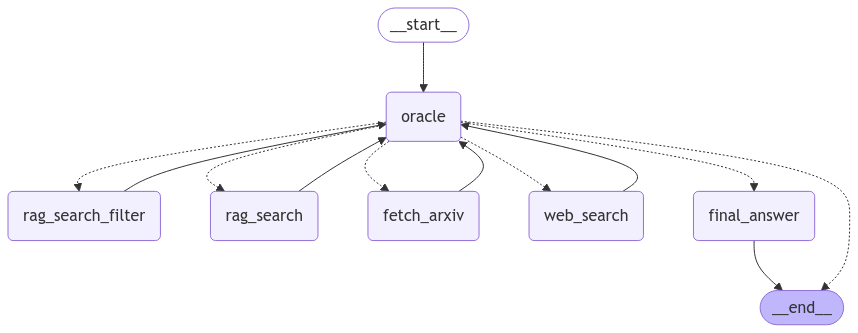

In [ ]:
from IPython.display import Image, display

display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))

## Run a research

Now we can query our multi-agent graph and watch the steps the oracle chooses to take with the agents and tools it has available to it.

In [ ]:
out = runnable.invoke({
    "input": "What are new findings in the crypto world which could help in investing?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'new findings in cryptocurrency investing 2023'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'new findings in cryptocurrency investing 2023'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'new findings in cryptocurrency investing 2023'}, log="2025 Cryptocurrency Adoption and Consumer Sentiment ...\nBitcoin's upward trend, which started in 2023, gained momentum in 2024, pushing prices to new all-time highs and outperforming the S&P 500.\nhttps://www.security.org/digital-security/cryptocurrency-annual-consumer-report/\n---\nCrypto Survey | Strategy&\n1. Rising allocated share of total wealth attributed to cryptocurrencies and digital assets across regions · 2. Bitcoin remains the most popular digital asset, ...\nhttps://www.strategyand.pwc.com/de/en/industries/financial-services/crypto-survey.html\n---\nThe Path Forward For Digital Assets and Crypto in 2023\nWe 

Now let's build a report and format the research.

In [ ]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
The cryptocurrency market is a dynamic and rapidly evolving sector, attracting investors with its potential for high returns. Recent developments in 2023 have introduced new findings that could influence investment strategies in this space.

RESEARCH STEPS
--------------
- Conducted a web search to gather recent findings in cryptocurrency investing for 2023.
- Utilized a specialist AI search to find detailed insights on cryptocurrency investment trends.
- Retrieved and analyzed an ArXiv paper to understand the broader implications of blockchain technologies and investment strategies.

REPORT
------
In 2023, the cryptocurrency market has seen significant developments that could impact investment strategies. A key finding is the continued upward trend of Bitcoin, which has outperformed traditional indices like the S&P 500. This trend suggests a growing confidence in Bitcoin as a store of value and a hedge against inflation, making it an attractive option for in